In [1]:
#
import numpy as np
import os, sys

#
sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag, cut
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, get_svfields_fg, get_svfields_ij, get_svfields_k, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin, plot_venn2
from io_ import match_coord

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table, Column

import pandas as pd

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

#
sys.path.insert(0, '/global/homes/q/qmxp55/DESI/ls_postages')
from main import html_postages

In [333]:
df = pd.read_csv('/global/cscratch1/sd/qmxp55/bgstargets_output/lsvi/results_Missed BGS in nominal_QCs-SOUTH_1.csv', sep=',')
master = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/lsvi/dr9m_BGS_rej_south.npy')

In [334]:
df

,Unnamed: 0,idx,christopher.addis@durham.ac.uk,mjwilson@lbl.gov,foo@foo,kellyadouglass@rochester.edu,ldrm11@durham.ac.uk,changhoon.hahn@princeton.edu,pauline.zarrouk@lpnhe.in2p3.fr,omar.a.ruiz-macias@durham.ac.uk,shaun.cole@durham.ac.uk
0,0,27421,NI,NI,NI,DS/H,GAL,NI,NI,GAL,GAL
1,1,22910,NI,NI,NI,GAL,GAL,NI,NI,GAL,GAL
2,2,16998,NI,NI,NI,STAR,STAR,NI,NI,STAR,STAR
3,3,21817,NI,NI,NI,GAL,GAL,NI,NI,GAL,GAL
4,4,31119,NI,NI,NI,GAL,GAL,NI,NI,GAL,GAL
...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,21558,NI,NI,NI,GAL,GAL,NI,NI,NI,NI
1996,1996,37194,NI,NI,NI,DS/H,DS/H,NI,NI,NI,NI
1997,1997,37485,NI,NI,NI,FRAG,FRAG,NI,NI,NI,NI
1998,1998,6112,NI,NI,NI,STAR,STAR,NI,NI,NI,NI


In [13]:
#
samples = ['centre_LG', 'centre_QC_FM_QC_FI_QC_FF']

for i in samples:
    print('in %s: \t %i' %(i, master[df['idx'].to_numpy()][i].sum()))
    

in centre_LG: 	 0
in centre_QC_FM_QC_FI_QC_FF: 	 2000


In [14]:
# users
users = df.columns.to_numpy()[1:]
labels = ['user', 'GAL', 'STAR', 'BT', 'DS/H', 'FRAG', 'JUNK', 'UNK', 'NI']
data = {i:[] for i in labels}

for lab in labels:
    for u in users:
        
        if lab == 'user':
            data[lab].append(u)
        else:
            data[lab].append((100/2000) * (df[u] == lab).sum())

tab = pd.DataFrame.from_dict(data)

In [15]:
tab

,user,GAL,STAR,BT,DS/H,FRAG,JUNK,UNK,NI
0,idx,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,christopher.addis@durham.ac.uk,4.4,3.95,0.20,1.70,0.50,0.15,3.05,86.05
2,mjwilson@lbl.gov,0.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00
3,foo@foo,0.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00
4,kellyadouglass@rochester.edu,13.6,8.45,2.35,6.20,3.60,1.00,0.80,64.00
5,ldrm11@durham.ac.uk,47.1,21.50,2.95,5.10,7.85,7.90,7.60,0.00
6,changhoon.hahn@princeton.edu,1.1,0.15,0.05,0.00,0.15,0.00,0.45,98.10
7,pauline.zarrouk@lpnhe.in2p3.fr,0.0,0.00,0.00,0.00,0.00,0.00,0.00,100.00
8,omar.a.ruiz-macias@durham.ac.uk,2.7,0.70,0.15,1.00,0.50,0.20,0.75,94.00
9,shaun.cole@durham.ac.uk,21.1,3.95,1.15,6.35,4.00,0.45,3.00,60.00


In [16]:
#
dr = 'dr9m'
survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'

cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy', mmap_mode='r+')

In [17]:
idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], master['RA'], master['DEC'], search_radius=0.1)

Doubly matched objects = 0
Final matched objects = 40288


In [18]:
master2 = cat[idx2]

In [24]:
users

array(['idx', 'christopher.addis@durham.ac.uk', 'mjwilson@lbl.gov',
       'foo@foo', 'kellyadouglass@rochester.edu', 'ldrm11@durham.ac.uk',
       'changhoon.hahn@princeton.edu', 'pauline.zarrouk@lpnhe.in2p3.fr',
       'omar.a.ruiz-macias@durham.ac.uk', 'shaun.cole@durham.ac.uk'],
      dtype=object)

GAL 0 942
STAR 0 430
JUNK 0 158


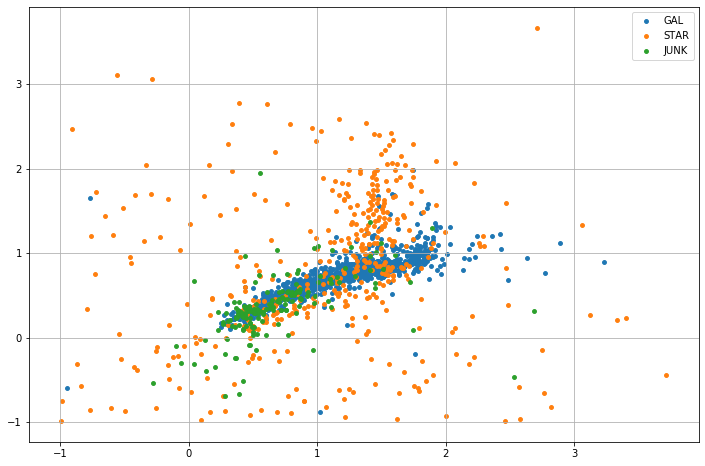

In [184]:
#
bgs = ((master2['BGSBITS'] & 2**(20)) != 0)
u = 'ldrm11@durham.ac.uk'
#u = 'foo@foo'
plt.figure(figsize=(12,8))

#for lab in labels[1:-1]:
for lab in ['GAL', 'STAR', 'JUNK']:
    
    idx = df['idx'][(df[u] == lab)]
    isBGS = np.sum(bgs[idx])
    isNotBGS = np.sum(~bgs[idx])
    print(lab, isBGS, isNotBGS)
    
#     for num, i in enumerate(['FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z']):
        
#         plt.subplot(1, 3, num+1)
#         plt.hist(master2[i][idx], 30, histtype='step', label=lab)
#         plt.xlabel(i)
#         plt.legend()
#         plt.grid()

    #plt.hist(master2['GMAG'][idx]-master2['RMAG'][idx], 30, label='G-r %s' %(lab))
    plt.scatter(master2['GMAG'][idx]-master2['RMAG'][idx], master2['RMAG'][idx]-master2['ZMAG'][idx], s=15, label='%s' %(lab))
    plt.legend()
    plt.grid()
    

In [187]:
.shape

(2000,)

## Number of Inspections (NINSP)

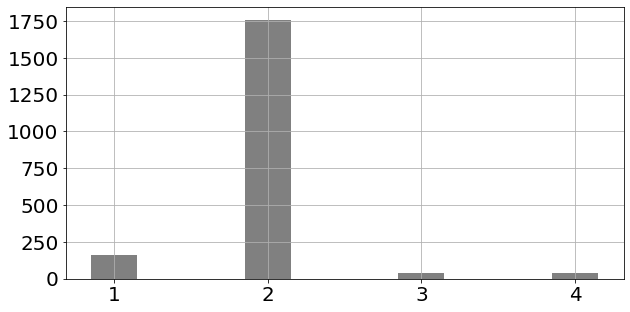

In [69]:
#
users = df.columns.to_numpy()[1:]
labels = ['user', 'GAL', 'STAR', 'BT', 'DS/H', 'FRAG', 'JUNK', 'UNK', 'NI']

NINSP = np.zeros_like(df['idx'], dtype=int)

for u in users[1:]:
    
    #print(u)
    ind = np.where(df[u] != 'NI')
    for i in ind:
        NINSP[i] += 1

NINSP_res = {str(i):np.sum(NINSP == i) for i in list(set(NINSP))}

#
plt.figure(figsize=(10,5))
#plt.bar(range(len(ff)), list(ff.values()), align='center')
#plt.xticks(range(len(ff)), list(ff.keys()))
plt.bar(NINSP_res.keys(), NINSP_res.values(), width=0.3, color='gray')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()


In [114]:
#
labels = ['GAL', 'STAR', 'BT', 'DS/H', 'FRAG', 'JUNK', 'UNK']
ind = np.where(NINSP == 2)[0]
sam = {i:np.zeros_like(ind, dtype=bool) for i in labels}
othr = {i:np.zeros_like(ind, dtype=bool) for i in labels}

for u in users[1:]:
    for lab in labels:
    
        if u == 'ldrm11@durham.ac.uk':
            sam[lab] |= (df[u][ind] == lab)
        else:
            othr[lab] |= (df[u][ind] == lab)


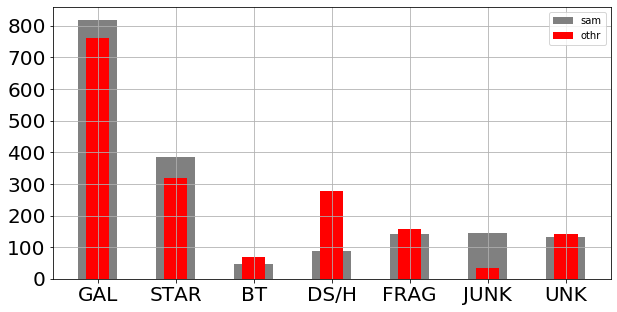

In [125]:
#
plt.figure(figsize=(10,5))
#plt.bar(range(len(ff)), list(ff.values()), align='center')
#plt.xticks(range(len(ff)), list(ff.keys()))
plt.bar(sam.keys(), [np.sum(i) for i in sam.values()], width=0.5, color='gray', label='sam')
plt.bar(othr.keys(), [np.sum(i) for i in othr.values()], width=0.3, color='red', label='othr')
plt.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

In [137]:
#
import seaborn as sns
def heatmap(data1, data2, cat1name=None, cat2name=None, ticks=None, vmin=None, vmax=None, filesave=None, fmt=".1f", log=False):
    
    import pandas as pd
    from matplotlib.colors import LogNorm
    N = len(data1.keys())
    keylist1 = list(data1.keys())
    keylist2 = list(data2.keys())
    matrix = [[0 for x in range(N)] for y in range(N)]
    
    from itertools import product
    for i,j in product(range(N), range(N)):
        
        matrix[i][j] = np.sum((data1[keylist1[i]]) & (data2[keylist2[j]]))
        #print(keylist1[i], keylist2[j], matrix[i][j]) #sanity check
        
    keylist_1 = [i+'_%s' %(cat1name) for i in keylist1]
    keylist_2 = [i+'_%s' %(cat2name) for i in keylist2]
    df = pd.DataFrame(np.array(matrix), columns=keylist_2, index=keylist_1)
    #df = pd.DataFrame(np.tril(np.array(matrix)), columns=keylist, index=keylist)
    #df.replace(0, np.nan, inplace=True)
    
    #if ticks is None: ticks = np.linspace(vmin, vmax, 5)
    
    fig = plt.figure(figsize=(12,10))
    log_norm = LogNorm(vmin=df.min().min(), vmax=df.max().max())
    if log: norm = log_norm
    else: norm = None
    ax = sns.heatmap(df, annot=True, annot_kws={"size": 14}, fmt=fmt, linewidths=.5, cmap='Reds',
                   norm=norm,
                    vmin = vmin, vmax=vmax,
                        cbar_kws={"ticks":ticks, 'label': r'N'})
    ax.figure.axes[-1].yaxis.label.set_size(22)
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    if filesave is not None:
        file = os.path.join(pathdir,filesave)
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)
        

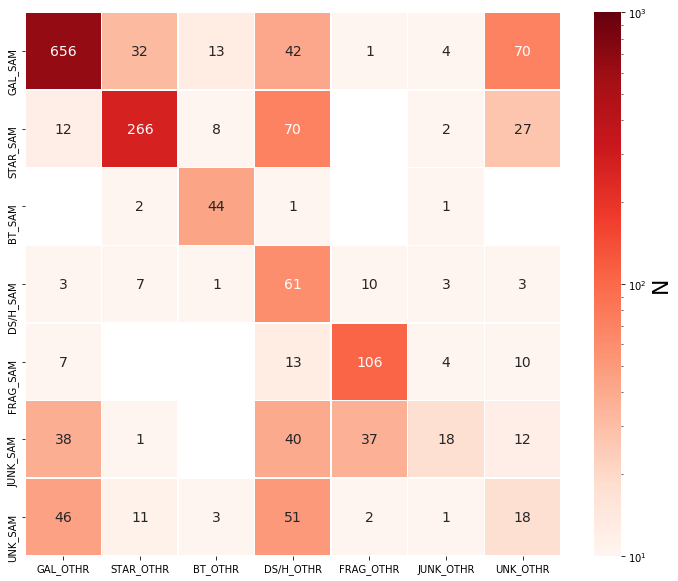

In [143]:
#
heatmap(data1=sam, data2=othr, cat1name='SAM', cat2name='OTHR', ticks=None, vmin=10, vmax=1000, filesave=None, fmt=".0f", log=True)

In [161]:
#
users = df.columns.to_numpy()[1:]
labels = ['GAL', 'STAR', 'BT', 'DS/H', 'FRAG', 'JUNK', 'UNK', 'NI']

Nlab = {i:np.zeros_like(df['idx'], dtype=int) for i in labels}

for u in users[1:]:
    for lab in labels:
        
        ind = np.where(df[u] == lab)
        for i in ind:
            Nlab[lab][i] += 1
            
#
Nlab['nonGAL'] = np.zeros_like(df['idx'], dtype=int)

for i in labels[1:-1]:
    
    #print(i)
    Nlab['nonGAL'] += Nlab[i]
    

STAR
BT
DS/H
FRAG
JUNK
UNK


In [171]:
#
clas = {}

clas['1'] = (Nlab['GAL'] >= 2) & (Nlab['nonGAL'] <2) #Confirmed Galaxy
clas['2'] = (Nlab['GAL'] < 2) & (Nlab['nonGAL'] >=2) #Confirmed non-galaxy
clas['3'] = ~(clas['1'] | clas['2']) #unknowns and inconsistent classification

j = 0
for key, val in clas.items():
    print(key, np.sum(val))
    j += np.sum(val)
print(j)


1 696
2 869
3 435
2000


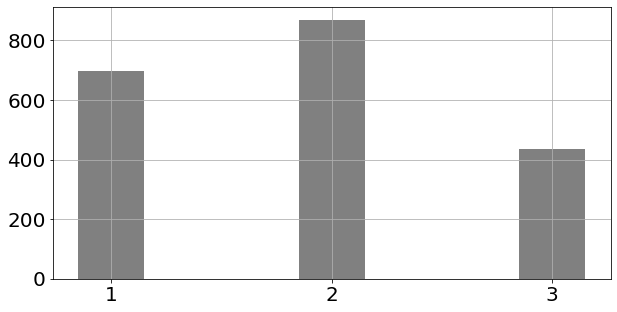

In [172]:
#
plt.figure(figsize=(10,5))
#plt.bar(range(len(ff)), list(ff.values()), align='center')
#plt.xticks(range(len(ff)), list(ff.keys()))
plt.bar(clas.keys(), [np.sum(i) for i in clas.values()], width=0.3, color='gray')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()


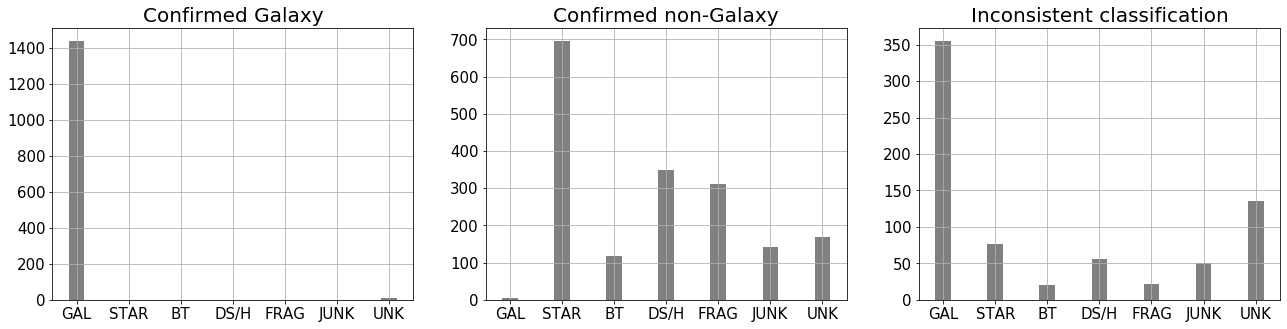

In [183]:
#
plt.figure(figsize=(22,5))
clas_name = {'1':'Confirmed Galaxy', '2':'Confirmed non-Galaxy', '3':'Inconsistent classification'}

for num, key in enumerate(clas.keys()):
    
    
    plt.subplot(1,3,num+1)

    plt.title(clas_name[key], size=20)
    plt.bar(labels[:-1], [np.sum(Nlab[i][clas[key]]) for i in labels[:-1]], width=0.3, color='gray')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    #plt.show()
    

In [276]:
master2.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'OBJID',
 'TYPE',
 'RA',
 'DEC',
 'GMAG',
 'RMAG',
 'ZMAG',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'SHAPE_R',
 'SHAPE_R_IVAR',
 'SHAPE_E1',
 'SHAPE_E1_IVAR',
 'SHAPE_E2',
 'SHAPE_E2_IVAR',
 'RFIBERMAG',
 'REF_CAT',
 'REF_ID',
 'G',
 'AEN',
 'MASKBITS',
 'FITBITS',
 'SERSIC',
 'SERSIC_IVAR',
 'FLUX_R',
 'BGSBITS')

In [321]:
#
def pandasDF(cols=None):
    
    tab_FM = {}
    clas_name = {'1':'Confirmed Galaxy', '2':'Confirmed non-Galaxy', '3':'Inconsistent classification'}

    #cols = ['RFIBERMAG', 'RMAG', 'SHAPE_R']

    for col in cols:

        tab_FM[col] = master2[col][df['idx']]


    tab_FM['clas'] = np.zeros(len(df['idx']), dtype='U30')

    for key, val in clas.items():
        #print(key, type(key))

        tab_FM['clas'][np.where(val)] = clas_name[key]

    df_FM = pd.DataFrame.from_dict(tab_FM)
    
    return df_FM

def pair(df=None, limit=None):
    
    def plot_unity(xdata, ydata, **kwargs):
        mn = min(xdata.min(), ydata.min())
        mx = max(xdata.max(), ydata.max())
        points = np.linspace(mn, limit, 100)
        plt.gca().plot(np.full(len(points), limit), points, color='k', marker=None,
                linestyle='--', linewidth=1.0)
        plt.gca().plot(points, np.full(len(points), limit), color='k', marker=None,
                linestyle='--', linewidth=1.0)

    grid = sns.pairplot(df, hue="clas", height=3, markers=["o", "s", "D"], 
                        hue_order=['Inconsistent classification', 'Confirmed non-Galaxy', 'Confirmed Galaxy'],
                           plot_kws={"s": 15})
    if limit is not None:
        grid.map_offdiag(plot_unity)
    

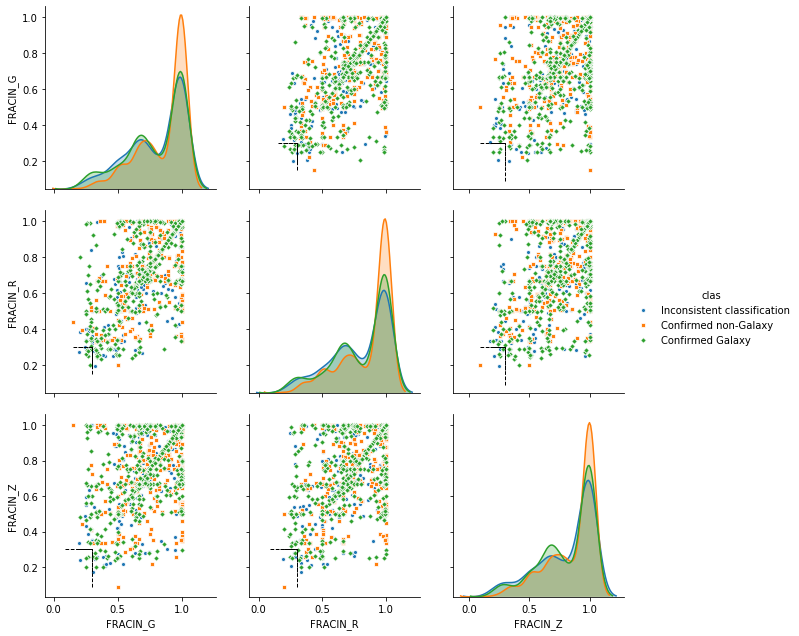

In [296]:
#
#cols = ['FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z']
cols = ['FRACIN_G', 'FRACIN_R', 'FRACIN_Z']
df_FI = pandasDF(cols=cols)
pair(df=df_FI, limit=0.3)

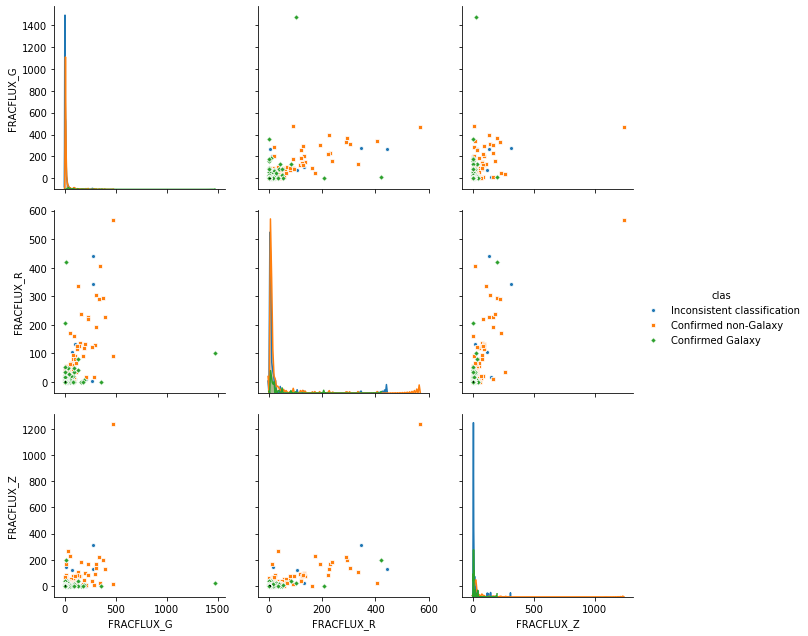

In [297]:
#
cols = ['FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z']
df_FI = pandasDF(cols=cols)
pair(df=df_FI, limit=5)

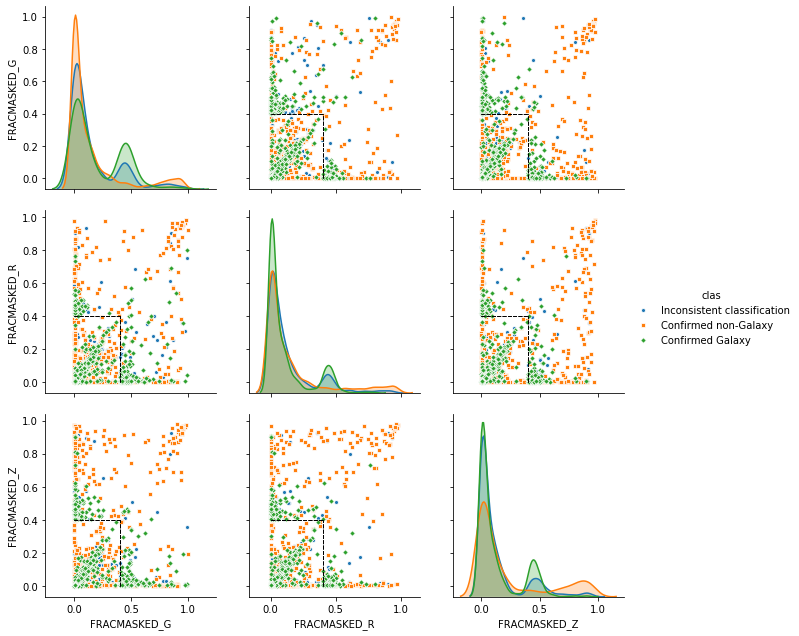

In [298]:
#
cols = ['FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z']
df_FI = pandasDF(cols=cols)
pair(df=df_FI, limit=0.4)

In [338]:
[df['idx']]

KeyError: 'idx'

In [337]:
#
tab = {}
tab['gr'] = master2['GMAG'][df['idx']] - master2['RMAG'][df['idx']]
tab['rz'] = master2['RMAG'][df['idx']] - master2['ZMAG'][df['idx']]
tab['FRACMASKED_G'] = master2['FRACMASKED_G'][df['idx']]
tab['FRACMASKED_R'] = master2['FRACMASKED_R'][df['idx']]
tab['FRACMASKED_Z'] = master2['FRACMASKED_Z'][df['idx']]

tab['clas'] = np.zeros(len(df['idx']), dtype='U30')

for key, val in clas.items():
    #print(key, type(key))

    tab['clas'][np.where(val)] = clas_name[key]

df = pd.DataFrame.from_dict(tab)

KeyError: 'idx'

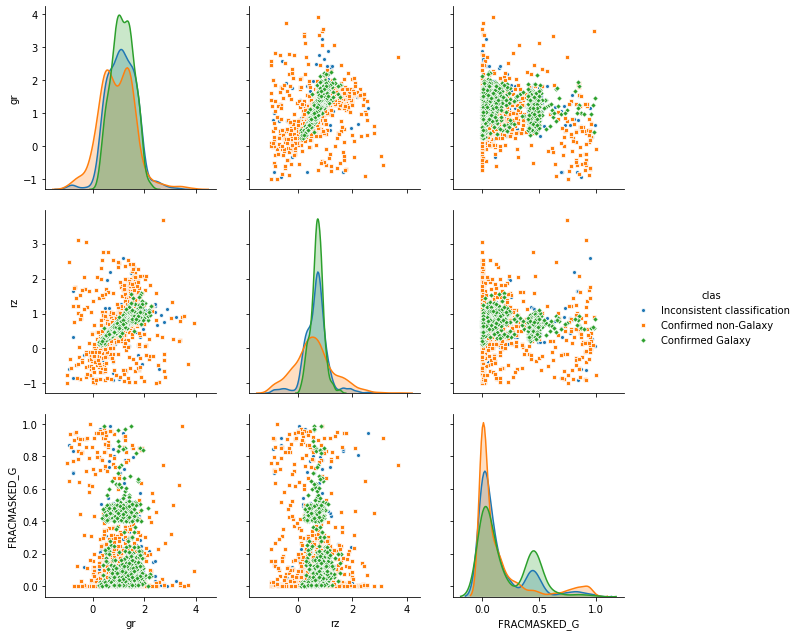

In [336]:
#
pair(df=df, limit=None)


* FRACMASKED_x < 0.4
* FRACIN_x > 0.3
* FRACFLUX_x < 5

* plot contours of only rejs by one of the bands in each of the FRACS*

* Plot FRACCLUX in log scale
* Do we want the FRACIN cut? For the objects that FAIL only in due FRACIN, get the fraction for each of the classification (i.e. COnfirmed Galaxy, .., etc.)
* Separate data in two samples based on colours:

    1) in the galaxy locus (using the contour method)
    
    2) outside galaxy locus
    
Then, for each of these compute:

* The fraction in (1) and in (2) out of the total sample (i.e. BGS)
* The fraction in (1) and in (2) out of the VI FRACS* sample (i.e. the one with the ~2000 objects)
    * For each one of this, break into the classifications (i.e. COnfirmed Galaxy, .., etc.)


In [299]:
#
cat = master2
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

fracs = np.ones_like(cat, dtype=bool)
bgsbutfracs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
for i in (11,12,13): 
    fracs &= ((cat['BGSBITS'] & 2**(i)) != 0)

#BGS rejected by fracs
bgs_fracs = (bgsbutfracs) & (~fracs)

fracs_re = np.ones_like(cat, dtype=bool)
for i in (14,15,16): 
    fracs_re &= ((cat['BGSBITS'] & 2**(i)) != 0)

#BGS rejected by fracs
bgs_fracs_re = (bgsbutfracs) & (~fracs_re)


In [307]:
#
clas_master = {i:np.zeros(len(master2['RA']), dtype=bool) for i in clas.keys()}

for key, val in clas.items():
    clas_master[key][df['idx'][val]] = True
    

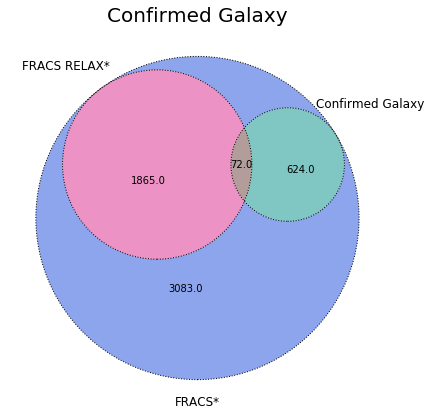

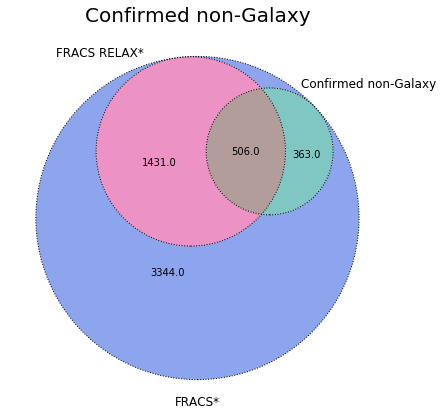

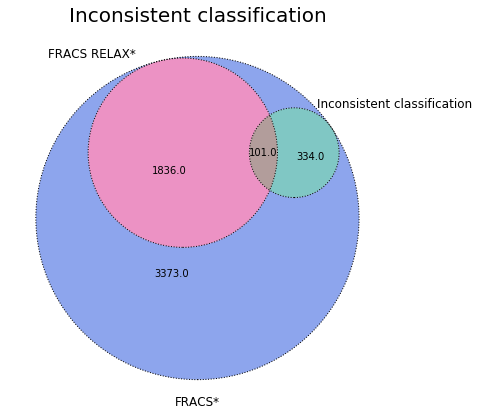

In [318]:
#
from QA import plot_venn3

for key, val in clas_master.items():
    
    plot_venn3(A=bgs_fracs_re, B=val, C=bgs_fracs, norm=1., 
               labels=('FRACS RELAX*', clas_name[key], 'FRACS*'), 
               file=None, title='%s' %(clas_name[key]), colors=None)
    